In [1]:
import cv2
import numpy as np
import time
from skimage.feature import hog
import librosa
import scipy

def extract_frames_from_video(video_path, take_every_n_frame = 50):
    # Открываем видеофайл
    cap = cv2.VideoCapture(video_path)
    
    # Проверяем, удалось ли открыть видеофайл
    if not cap.isOpened():
        print(f"Ошибка: не удалось открыть видеофайл {video_path}")
        return []

    frames = []
    c = 0
    
    while cap.isOpened():
        # Читаем кадр за кадром
        ret, frame = cap.read()
        c+=1
        
        if not ret:
            break
        
        # Добавляем кадр в список
        if c%take_every_n_frame == 0: frames.append(frame)
    
    # Освобождаем захват видео
    cap.release()
    
    return np.array(frames)

def get_the_most_complicated_frames(video_path, take_every_n_frame = 50, border_of_std = 0.1):
    frames = extract_frames_from_video(video_path, take_every_n_frame)
    print(f"Извлечено {len(frames)} кадров из видео")

    average_hogs = []
    for i in range(len(frames)):
        # Загрузка изображения
        image = cv2.cvtColor(frames[i],cv2.COLOR_BGR2GRAY)
        
        #Вычисление HOG
        fd = hog(image, pixels_per_cell=(16, 16), cells_per_block=(4, 4))
        # Вычисление среднего значения HOG дескрипторов
        average_hog_descriptor = np.mean(fd) #выше коэффициент - больше деталей и обьектов в изображении
        average_hogs.append(average_hog_descriptor)
        
    entropies = []
    for input_image in frames:
        # Загрузка изображения
        image = cv2.cvtColor(input_image,cv2.COLOR_RGB2GRAY)
       
        hist = cv2.calcHist([image], [0], None, [256], [0, 256])
        # Нормализация гистограммы
        hist = hist / np.sum(hist)
        
        # Вычисление меры энтропии
        entropy = -np.sum(hist * np.log2(hist + 1e-10))
        entropies.append(entropy)

    entropies_ = entropies-np.mean(entropies) 

    more_detailed_than_usual_frame_indexes = np.where((entropies_ > np.mean(entropies_)+border_of_std*np.std(entropies_)) & 
                                                      (average_hogs > np.mean(average_hogs)+border_of_std*np.std(average_hogs)))[0]
    less_detailed_than_usual_frame_indexes = np.where((entropies_ < np.mean(entropies_)-border_of_std*np.std(entropies_)) & 
                                                      (average_hogs < np.mean(average_hogs)-border_of_std*np.std(average_hogs)))[0]
    
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    mspf = 1000/fps #milliseconds per frame

    coef = []

    for ind in list(more_detailed_than_usual_frame_indexes):
        coef.append([ ( round((abs(int(ind)-1)*mspf)), round((int(ind)+1)*mspf) ), abs(float(entropies_[ind]+ average_hogs[ind])) ])

    for ind in list(less_detailed_than_usual_frame_indexes):
        coef.append([ ( round((abs(int(ind)-1)*mspf)), round((int(ind)+1)*mspf) ), -1*abs(float(entropies_[ind]+ average_hogs[ind])) ])
    
    coef.sort(key=lambda x: x[0][0])
    
    return coef

def audio_analysis(video_path, seconds_between_grouped_peaks = 1) -> list[tuple[tuple[int, int], float]]:
    audio, sr = librosa.load(video_path)
    rms = librosa.feature.rms(y=audio)[0]

    onset_env = librosa.onset.onset_strength(y=audio, sr=sr)
    peak_indices = np.where((onset_env > np.mean(onset_env)) & (rms > np.mean(rms)))[0]

    times = librosa.times_like(onset_env, sr=sr)
    t = (seconds_between_grouped_peaks * sr * len(times)) / np.shape(audio)[0]
    clusters = scipy.cluster.hierarchy.fcluster(
        scipy.cluster.hierarchy.linkage(peak_indices[:, None], method='single'),
        t=t, criterion='distance')

    segment_energies = []
    for cluster_id in set(clusters):
        cluster_indices = peak_indices[clusters == cluster_id]
        segment_energy = np.sum(rms[cluster_indices])
        segment_energies.append(((round(times[cluster_indices[0]] * 1000),round(times[cluster_indices[-1]] * 1000)), segment_energy))

    segment_energies.sort(key=lambda x: x[0][0])

    return segment_energies

In [2]:
def min_max_norm(data):
    # Масштабирование Min-Max
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data
    
def merge_sections(first_seq, second_seq, third_seq, weight_of_first_seq, weight_of_second_seq, weight_of_third_seq):
    out = []
    
    time1 = [i[0] for i in first_seq]
    coef1 = min_max_norm([i[1] for i in first_seq])
    
    time2 = [i[0] for i in second_seq]
    coef2 = min_max_norm([i[1] for i in second_seq])
    
    time3 = [i[0] for i in third_seq]
    coef3 = min_max_norm([i[1] for i in third_seq])
    
    a = np.zeros(max(first_seq[-1][0][1],second_seq[-1][0][1], third_seq[-1][0][1]))
    
    for sec in range(len(first_seq)):
        a[time1[sec][0]:time1[sec][1]+1] += coef1[sec] * weight_of_first_seq

    for sec in range(len(second_seq)):
        a[time2[sec][0]:time2[sec][1]+1] += coef2[sec] * weight_of_second_seq

    for sec in range(len(third_seq)):
        a[time3[sec][0]:time3[sec][1]+1] += coef3[sec] * weight_of_third_seq

    s, f = 0,0
    n = a[0]
    for ms in a:
        if ms == n: f+=1
        else:
            if f-s > 10 and n!=0: out.append([(s,f),float(n)])
            n=ms
            s = f+1
            f = s
        
    return out

In [3]:
def mult_and_merge_two_sections(main_seq, mult_seq, w_of_mult = 1):
    out = []
    
    time1 = [i[0] for i in main_seq]
    coef1 = min_max_norm([i[1] for i in main_seq])
    
    time2 = [i[0] for i in mult_seq]
    coef2 = min_max_norm([i[1] for i in mult_seq])
    
    a = np.ones(max(main_seq[-1][0][1],mult_seq[-1][0][1]))
    
    for sec in range(len(main_seq)):
        a[time1[sec][0]:time1[sec][1]+1] += coef1[sec]

    for sec in range(len(mult_seq)):
        a[time2[sec][0]:time2[sec][1]+1] *= coef2[sec] * w_of_mult

    s, f = 0,0
    n = a[0]
    for ms in a:
        if ms == n: f+=1
        else:
            if f-s > 0 and n!=0: out.append([(s,f),float(n)])
            n=ms
            s = f+1
            f = s
        
    return out

def add_and_merge_two_sections(main_seq, add_seq, w_of_add = 1):
    out = []
    
    time1 = [i[0] for i in main_seq]
    coef1 = min_max_norm([i[1] for i in main_seq])
    
    time2 = [i[0] for i in add_seq]
    coef2 = min_max_norm([i[1] for i in add_seq])
    
    a = np.zeros(max(main_seq[-1][0][1],add_seq[-1][0][1]))
    
    for sec in range(len(main_seq)):
        a[time1[sec][0]:time1[sec][1]+1] += coef1[sec]

    for sec in range(len(add_seq)):
        a[time2[sec][0]:time2[sec][1]+1] += coef2[sec] * w_of_add

    s, f = 0,0
    n = a[0]
    for ms in a:
        if ms == n: f+=1
        else:
            if f-s > 0 and n!=0: out.append([(s,f),float(n)])
            n=ms
            s = f+1
            f = s
        
    return out

In [16]:
def get_timecodes(semantic,compl_coef,audio_peaks, aud_c = 2, compl_c = 1, k=0.1, points_between_peaks = 0.1, epsilon_to_cut = 1000):
    out = mult_and_merge_two_sections(add_and_merge_two_sections(semantic, audio_peaks, aud_c), compl_coef,compl_c)
    coefs = np.array([subarray[1] for subarray in out])
    out_indices = np.where(coefs > np.mean(coefs)+np.std(coefs)*k)[0]

    out_data_for_dist = []
    for i in out_indices:
        out_data_for_dist.append([(out[i][0][0]+out[i][0][1])/2, (1+coefs[i])**2])

    clusters = scipy.cluster.hierarchy.fcluster(
        scipy.cluster.hierarchy.linkage(out_data_for_dist, method='single'),
        t=points_between_peaks, criterion='distance')

    print('Num of clusters =',len(set(clusters)))
    
    segments = []
    for cluster_id in set(clusters):
        cluster_indices = out_indices[clusters == cluster_id]
        segment = 0
        for i in cluster_indices:
            segment += out[i][1]
        len_of_sec = out[cluster_indices[-1]][0][1]-out[cluster_indices[0]][0][0] + 2*epsilon_to_cut
        if(len_of_sec > 10000 and len_of_sec < 3*60*1000 ): segments.append([(abs(out[cluster_indices[0]][0][0]-epsilon_to_cut), (out[cluster_indices[-1]][0][1]+epsilon_to_cut)), segment])
    
    segments.sort(key=lambda x: x[1], reverse = True)
    return segments

In [5]:
video_path = "/Users/polinanazarova/Desktop/2ef3ec7442459323bfb283992ffe001f.mp4"

In [6]:
start_time = time.time()

compl_coef = get_the_most_complicated_frames(video_path)
audio_peaks = audio_analysis(video_path)

end_time = time.time()
execution_time = end_time - start_time
print(f"Время выполнения: {execution_time} секунд")

Извлечено 1089 кадров из видео


/var/folders/2l/9ngbv0ln3bg2rcxscgv7604m0000gn/T/ipykernel_42859/440141378.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(video_path)
/Users/polinanazarova/anaconda3/envs/vseross2024/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Время выполнения: 80.49829506874084 секунд


In [7]:
semantic = [((380, 1360), 0.036502021551132205), ((1860, 6060), 0.078927344083786), ((9640, 21030), 0.0759954571723938), ((23900, 36780), 0.23834616911822362), ((37840, 44840), 0.36408692352912003), ((55000, 62660), 0.12913507328313942), ((63980, 73520), 0.3086738204514539), ((79220, 91940), 0.2468099949757258), ((93400, 99960), 0.34799668648663695), ((107260, 112780), 0.0889614591231713), ((120180, 127300), 0.26232974654749813), ((132720, 142440), 0.2581999310038307), ((148400, 160280), 0.45783770506580673), ((164300, 167200), 0.0866390287876129), ((168160, 179420), 0.4097197824908842), ((190440, 205420), 0.32721000665273414), ((214200, 221100), 0.3002723197142283), ((225020, 237380), 0.20933324632973505), ((238300, 241900), 0.05155053138732911), ((242360, 251480), 0.25314470827579494), ((255640, 264140), 0.1537088158455762), ((266240, 273920), 0.27423309946060187), ((274620, 281380), 0.17632548488103428), ((290040, 301740), 0.1841247959778859), ((305700, 309200), 0.061373877525329586), ((311460, 324520), 0.3012875843379233), ((326460, 330220), 0.17777977585792545), ((345700, 352680), 0.40767808887693613), ((357880, 365920), 0.08896414518356324), ((366920, 379910), 0.39664962870233195), ((382860, 395480), 0.3475463814394815), ((398940, 401620), 0.0685522973537445), ((402160, 446120), 0.26963879381616923), ((449860, 455680), 0.10523865977923075), ((459320, 473960), 0.5461385321888058), ((478040, 499780), 0.4226277373053812), ((506680, 509160), 0.13407998979091645), ((513020, 522480), 0.10461180508136751), ((523559, 538730), 0.2843903257566339), ((545020, 551520), 0.16579030411584036), ((561480, 569260), 0.22766022461431992), ((571220, 576480), 0.08065167109171546), ((584600, 605560), 0.38251394585865295), ((606460, 622540), 0.20152455839243802), ((624900, 630540), 0.18003778623210065), ((631180, 637220), 0.05557805962032742), ((641040, 647520), 0.23903473582532675), ((648280, 655620), 0.132595201513984), ((660560, 662660), 0.06511958837509156), ((664220, 670480), 0.24698557323879675), ((674660, 683640), 0.2593384804824987), ((700900, 717320), 0.22610539964267182), ((722740, 732460), 0.22378878202931646), ((739820, 751400), 0.17080513555556529), ((752760, 757440), 0.4028744123876095), ((761120, 783960), 0.36508662700653083), ((784380, 790820), 0.19716769365163953), ((791960, 795320), 0.04582442939281463), ((798700, 811760), 0.18985638436343932), ((814060, 824080), 0.34924727082252494), ((831560, 838100), 0.29432838968932634), ((838720, 848420), 0.4477930911209273), ((850920, 856920), 0.4132050295670827), ((861440, 879660), 0.28142266500563845), ((888660, 907440), 0.3190422282407159), ((909560, 911440), 0.08954181671142579), ((913060, 919940), 0.2016941443085671), ((928220, 930820), 0.040085726976394655), ((939640, 956300), 0.27159578658285605), ((958500, 966620), 0.22876574322581295), ((971840, 997900), 0.1966964323073626), ((999900, 1008040), 0.25940669449892917), ((1016260, 1036940), 0.19280038013750186), ((1037319, 1045160), 0.1776569249729315), ((1048440, 1162440), 0.41248823531130524), ((1175100, 1198920), 0.39267153628801904), ((1200560, 1214460), 0.41168544292449955), ((1215440, 1234720), 0.20579502398059474), ((1253140, 1276880), 0.19299656723407985), ((1282760, 1287860), 0.1100797098875046), ((1293400, 1300260), 0.169783790409565), ((1301700, 1306020), 0.08678311109542847), ((1314980, 1345940), 0.22366055792028255), ((1349360, 1358340), 0.4151618242263795), ((1360820, 1365000), 0.2779979893794427), ((1367420, 1386220), 0.35807576210875264), ((1387060, 1400580), 0.142349230892518), ((1401860, 1407740), 0.12875191271305084), ((1410760, 1414000), 0.054007089138031), ((1414560, 1425780), 0.35933259195751616), ((1426200, 1435060), 0.27894630255522557), ((1435580, 1439030), 0.044864740967750553), ((1447260, 1452080), 0.1563167561184276), ((1456140, 1473040), 0.35356562117050444), ((1485160, 1524040), 0.4651063819548914), ((1539260, 1544080), 0.05904404520988465), ((1547440, 1550060), 0.10439618170261382), ((1554540, 1559380), 0.10313833206892013), ((1567980, 1578820), 0.49475858410199475), ((1583480, 1621780),0.21822943500725606), ((1641340, 1649740), 0.26957193655627115), ((1655060, 1666080), 0.3912892671007858), ((1667220, 1684660), 0.27013297600623887), ((1695640, 1701800), 0.2318070464664035), ((1708740, 1715280), 0.2295611971616745), ((1718140, 1723420), 0.1098077568140897), ((1732500, 1746640), 0.3431653596852955), ((1747140, 1785880), 0.3000939243964934)]

In [24]:
timecodes = get_timecodes(semantic,compl_coef,audio_peaks, aud_c = 1, compl_c = 0.5, k=1, points_between_peaks = 800, epsilon_to_cut = 500)
t = timecodes
t.sort(key=lambda x: x[0][0])

duration = []
for i in t:
    duration.append((i[0][1]-i[0][0])/1000)

coef_of_long_vert_vid = np.mean(duration)+np.std(duration)
long_videos = []
short_videos = []
for i in range(len(t)):
    if duration[i] >= coef_of_long_vert_vid: long_videos.append(t[i])
    else: short_videos.append(t[i])

Num of clusters = 113


In [25]:
for ind in range(len(timecodes)):
    print('Clip #', ind+1, sep ='')
    print('--Start ', (timecodes[ind][0][0] // 1000) // 60, ':', (timecodes[ind][0][0] // 1000) % 60, sep ='')
    print('--End ', (timecodes[ind][0][1] // 1000) // 60, ':', (timecodes[ind][0][1] // 1000) % 60, sep ='')
    print('!-Length ', ((timecodes[ind][0][1]-timecodes[ind][0][0]) // 1000) // 60, ':', ((timecodes[ind][0][1]-timecodes[ind][0][0]) // 1000) % 60, sep ='')
    print('--Coef ', round(timecodes[ind][1],2), sep ='')
    print()

Clip #1
--Start 1:3
--End 1:14
!-Length 0:10
--Coef 1.63

Clip #2
--Start 1:18
--End 1:30
!-Length 0:11
--Coef 1.55

Clip #3
--Start 2:47
--End 2:59
!-Length 0:12
--Coef 1.96

Clip #4
--Start 3:9
--End 3:25
!-Length 0:15
--Coef 1.85

Clip #5
--Start 5:10
--End 5:25
!-Length 0:14
--Coef 1.66

Clip #6
--Start 6:6
--End 6:20
!-Length 0:13
--Coef 1.75

Clip #7
--Start 6:41
--End 7:23
!-Length 0:41
--Coef 1.71

Clip #8
--Start 7:57
--End 8:10
!-Length 0:12
--Coef 1.78

Clip #9
--Start 9:44
--End 10:6
!-Length 0:21
--Coef 1.9

Clip #10
--Start 10:5
--End 10:16
!-Length 0:10
--Coef 1.65

Clip #11
--Start 11:45
--End 11:57
!-Length 0:12
--Coef 1.53

Clip #12
--Start 12:2
--End 12:12
!-Length 0:10
--Coef 1.53

Clip #13
--Start 13:33
--End 13:44
!-Length 0:11
--Coef 1.65

Clip #14
--Start 13:58
--End 14:8
!-Length 0:10
--Coef 1.8

Clip #15
--Start 15:39
--End 15:56
!-Length 0:17
--Coef 1.73

Clip #16
--Start 16:11
--End 16:38
!-Length 0:27
--Coef 1.86

Clip #17
--Start 16:55
--End 17:7
!-Length 

# Распределение клипов по видео

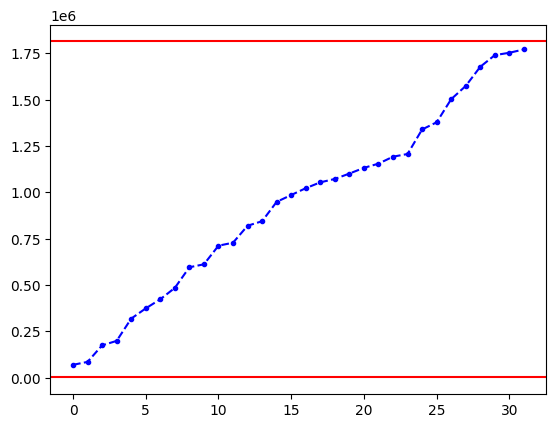

In [26]:
from matplotlib import pyplot as plt

t = timecodes
t.sort(key=lambda x: x[0][0])

q = []

plt.axhline(audio_peaks[-1][0][1], color = 'r')
plt.axhline(audio_peaks[0][0][0], color = 'r')

for i in t:
    q.append((i[0][0] + i[0][1])/2)

plt.plot(q, marker='.', linestyle='--', color='b')
plt.show()

# Распределение интересных моментов по видео

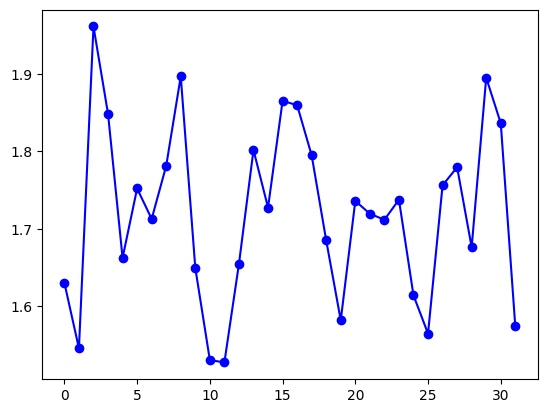

In [27]:
t = timecodes
t.sort(key=lambda x: x[0][0])

interest = np.array([subarray[1] for subarray in t])
plt.plot(interest, marker='o', linestyle='-', color='b')
plt.show()

# Распределение длительностей интересных моментов по видео

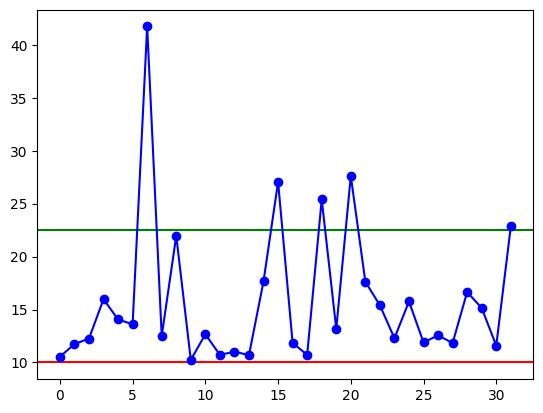

In [28]:
t = timecodes
t.sort(key=lambda x: x[0][0])

duration = []
for i in t:
    duration.append((i[0][1]-i[0][0])/1000)

if(np.mean(duration)<120): plt.axhline(10, color = 'r')
if(np.mean(duration)>60): plt.axhline(3*60, color = 'r')

plt.axhline(np.mean(duration)+np.std(duration), color = 'g')
plt.plot(duration, marker='o', linestyle='-', color='b')
plt.show()

In [658]:
t[7][0][0] / 1000/60

7.959033333333333

In [7]:
# Пример известных входных данных и соответствующих ожидаемых выходных данных
X_known = [semantic, compl_coef, audio_peaks]  # Ваши известные входные данные
y_known = np.array([(0,15*1000),(46*1000, (1*60+29)*1000), ((1*60+39)*1000, (1*60+52)*1000),
((1*60+53)*1000, (2*60+47)*1000),((15*60+39)*1000, (16*60+50)*1000),
((17*60+34)*1000, (18*60+47)*1000),((25*60+24)*1000, (25*60+38)*1000)])  # Ожидаемые выходные данные

In [8]:
# Пример функции нарезки видео (может изменяться в зависимости от вашей задачи)
def video_clipping_function(X, k, points_between_peaks, epsilon_to_cut, w1,w2,w3):
    overall = get_timecodes(X[0],X[1],X[2], k = k, points_between_peaks = points_between_peaks, epsilon_to_cut = epsilon_to_cut, w1 = w1, w2 = w2, w3 = w3)
    return overall

In [22]:
def loss_function(params, X_known, y_known):
    param1, param2, param3, param4, param5, param6 = params
    y_pred = video_clipping_function(X_known, param1, param2, param3, param4, param5, param6)

    m1=[]
    m2=[]
    
    for i in y_known:
        m1.append([i,1])
        
    for i in y_pred:
        m2.append([(int(i[0][0]),int(i[0][1])),1])

    ov = merge_two_sections(m1, m2)

    loss = 0
    for i in ov:
        loss+= (i[1] == 2) * (i[0][1]-i[0][0])

    return -loss

In [23]:
# Начальные значения параметров
initial_params = np.array([0.1, 0.1, 1000, 10, 5, 25])


last_err = 0
now_err = loss_function(initial_params,X_known, y_known)
print(now_err)
last_err = now_err

4580647165928.1045
